In [3]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="keras")


In [4]:
# Specify dataset path
dataset_path = "E:/SML Project/plantvillagedataset/color"  

# Define ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values
    validation_split=0.2,      # Split dataset: 80% train, 20% validation
    rotation_range=30,         # Random rotations
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True       # Random horizontal flips
)

# Prepare training data generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),  # Resize images
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training',
    shuffle=True
)

# Prepare validation data generator
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),  # Resize images
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 18110 images belonging to 38 classes.
Found 4510 images belonging to 38 classes.


In [5]:
# Build the CNN model
model = Sequential([
    Input(shape=(150, 150, 3)),  # Input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization to reduce overfitting
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,833,254 (18.44 MB)

 Trainable params: 4,833,254 (18.44 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import time
from tensorflow.keras.callbacks import Callback

# Define a custom callback to display remaining time
class TimeRemainingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()  # Record the training start time

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self.epoch_start_time = time.time()  # Record the first epoch start time

    def on_epoch_end(self, epoch, logs=None):
        current_time = time.time()
        time_per_epoch = current_time - self.epoch_start_time
        remaining_epochs = self.params['epochs'] - (epoch + 1)
        estimated_time_remaining = time_per_epoch * remaining_epochs
        
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']} completed.")
        print(f"Time per epoch: {time_per_epoch:.2f} seconds.")
        print(f"Estimated time remaining: {estimated_time_remaining:.2f} seconds.\n")

        # Update epoch start time for the next epoch
        self.epoch_start_time = current_time

# Instantiate the custom callback
time_remaining_callback = TimeRemainingCallback()

# Train the model with the custom callback
history = model.fit(
    train_generator,
    epochs=10,  # Adjust epochs for better results
    validation_data=validation_generator,  # Use validation data for evaluation
    callbacks=[time_remaining_callback]  # Add the custom callback
)


Epoch 1/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.2435 - loss: 2.9562
Epoch 1/10 completed.
Time per epoch: 228.11 seconds.
Estimated time remaining: 2052.96 seconds.

566/566 ━━━━━━━━━━━━━━━━━━━━ 228s 399ms/step - accuracy: 0.2436 - loss: 2.9555 - val_accuracy: 0.5528 - val_loss: 1.6884
Epoch 2/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4997 - loss: 1.7978
Epoch 2/10 completed.
Time per epoch: 198.52 seconds.
Estimated time remaining: 1588.20 seconds.

566/566 ━━━━━━━━━━━━━━━━━━━━ 199s 351ms/step - accuracy: 0.4998 - loss: 1.7976 - val_accuracy: 0.6831 - val_loss: 1.1189
Epoch 3/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5819 - loss: 1.4189
Epoch 3/10 completed.
Time per epoch: 197.05 seconds.
Estimated time remaining: 1379.33 seconds.

566/566 ━━━━━━━━━━━━━━━━━━━━ 197s 348ms/step - accuracy: 0.5819 - loss: 1.4189 - val_accuracy: 0.7319 - val_loss: 0.9241
Epoch 4/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6188 - loss

In [6]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot training vs. validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
....

SyntaxError: invalid syntax (3273200680.py, line 14)

In [6]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


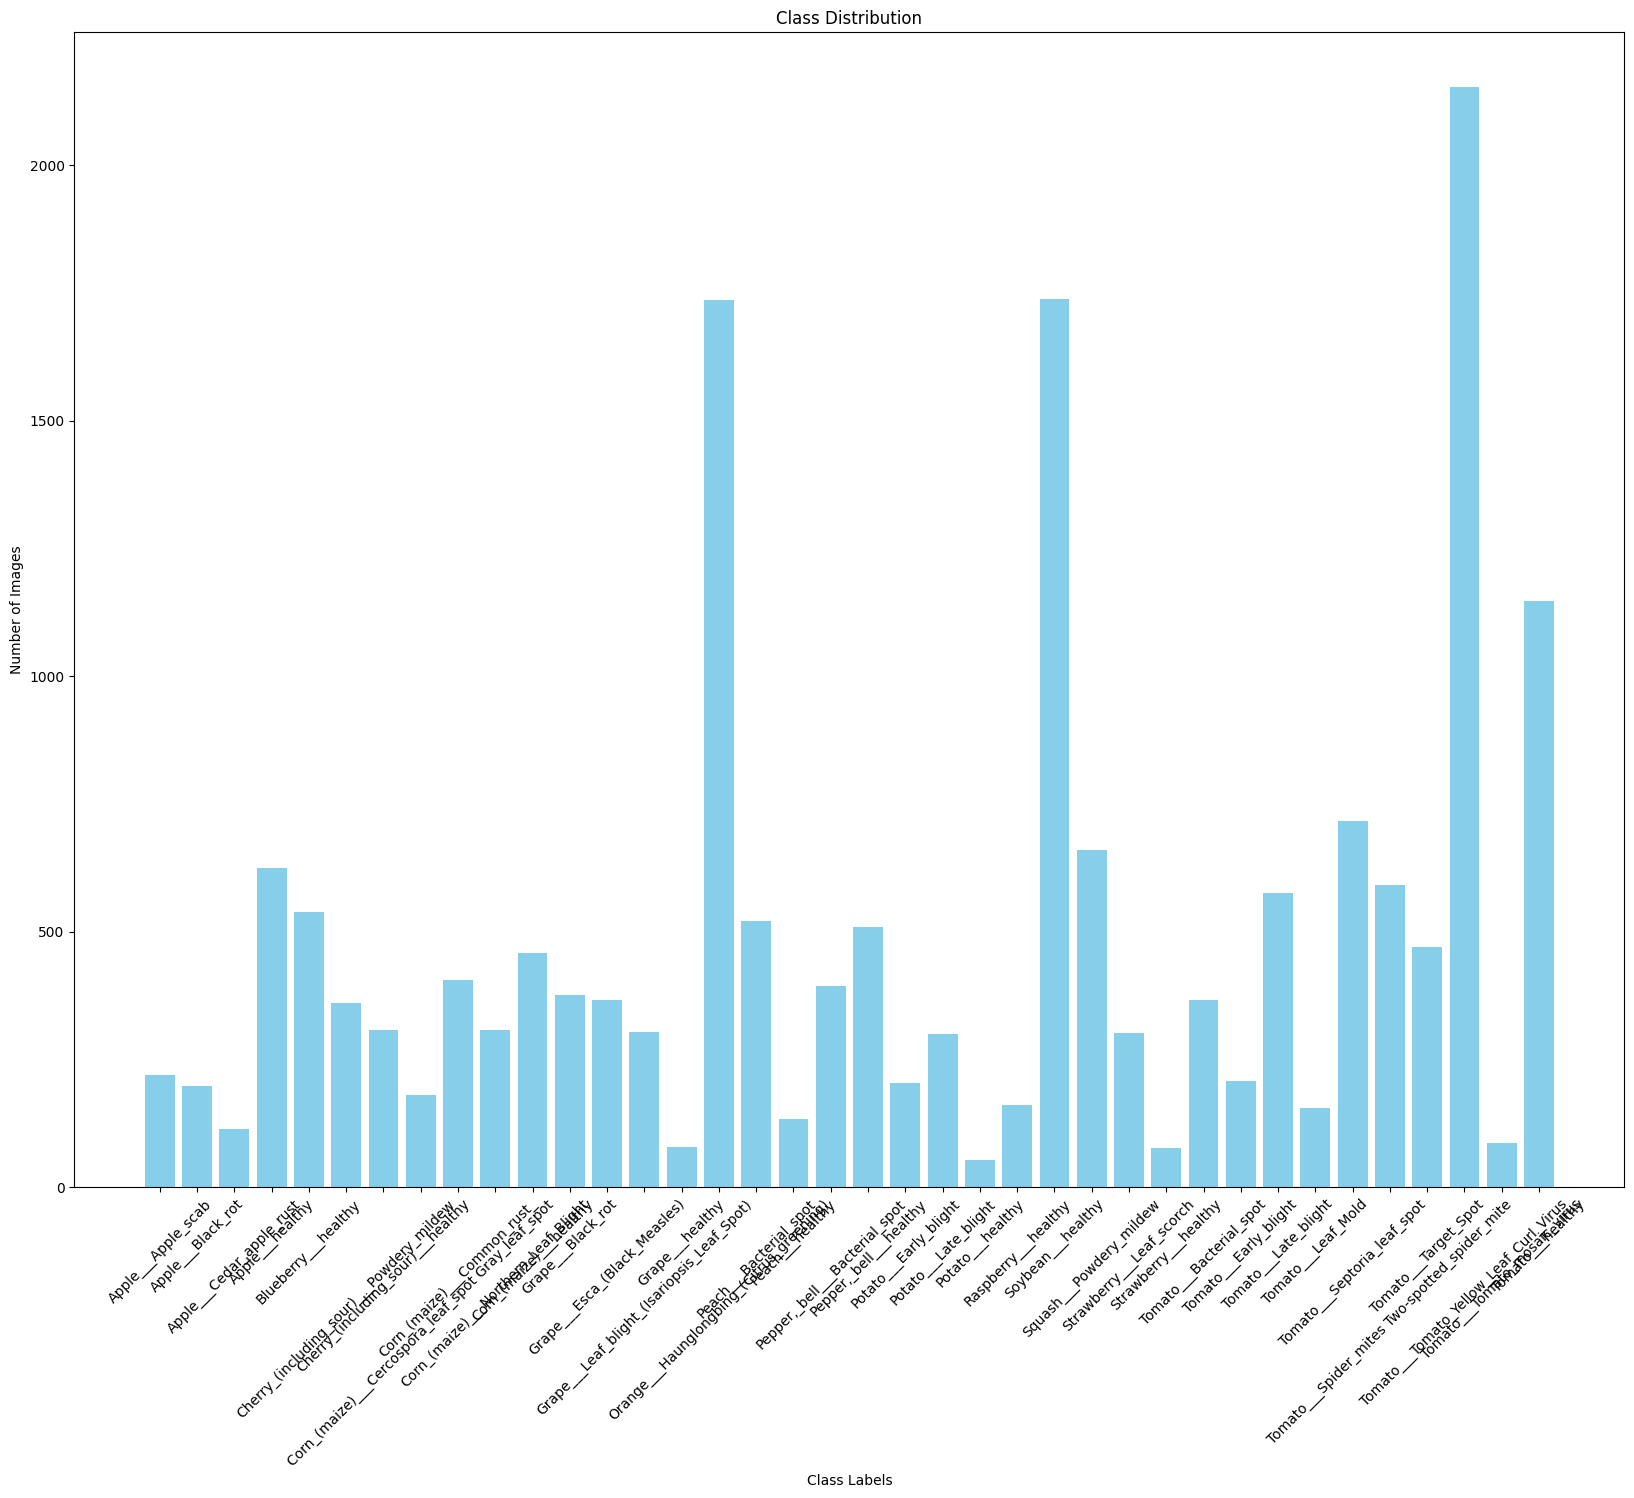

In [11]:
# Get the actual class counts from train_generator
class_counts = np.unique(train_generator.classes, return_counts=True)[1]  # Count occurrences of each class
class_labels = list(train_generator.class_indices.keys())  # Class names

# Plot the class distribution
plt.figure(figsize=(20, 15))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [5]:
import os

def plot_sample_images(train_generator, num_images_per_class=5):
    class_names = train_generator.class_indices.keys()
    plt.figure(figsize=(15, len(class_names) * 3))
    
    for class_index, class_name in enumerate(class_names):
        # Filter images belonging to the current class
        class_image_paths = [img for img in train_generator.filenames if class_name in img]
        random_images = random.sample(class_image_paths, min(len(class_image_paths), num_images_per_class))
        
        for i, img_path in enumerate(random_images):
            # Load and display the image
            img_full_path = os.path.join(train_generator.directory, img_path)
            img = image.load_img(img_full_path, target_size=(150, 150))
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
plot_sample_images(train_generator)


NameError: name 'random' is not defined

<Figure size 1500x11400 with 0 Axes>

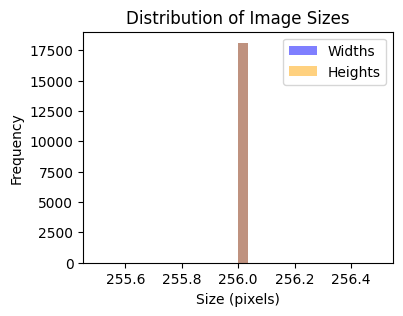

In [15]:
from PIL import Image

def analyze_image_sizes(generator):
    widths = []
    heights = []
    
    for img_path in generator.filenames:
        img_full_path = os.path.join(generator.directory, img_path)
        with Image.open(img_full_path) as img:
            widths.append(img.width)
            heights.append(img.height)

    plt.figure(figsize=(4, 3))
    plt.hist(widths, bins=30, alpha=0.5, label='Widths', color='blue')
    plt.hist(heights, bins=30, alpha=0.5, label='Heights', color='orange')
    plt.title('Distribution of Image Sizes')
    plt.xlabel('Size (pixels)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Analyze image sizes
analyze_image_sizes(train_generator)


In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the trained model
# Assuming the model is already loaded and trained, and it's named 'model'
# If not, you can load the model using model = tf.keras.models.load_model('model_path')

# Load and preprocess an image for prediction
img_path = r"C:\Users\HP\Downloads\images.jpg"  # Replace with the actual path to your test image

# Resize the image to match model input size (assuming the model expects 150x150 size)
img = image.load_img(img_path, target_size=(150, 150))  # Resize to model input size
img_array = image.img_to_array(img) / 255.0  # Convert image to array and normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension for prediction

# Predict the disease class
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get the index of the class with the highest probability

# Map the predicted index to class labels
class_names = list(train_generator.class_indices.keys())  # Get the class labels from the training data generator
predicted_class = class_names[predicted_class_index]  # Get the predicted class name
print(f"The predicted class is: {predicted_class}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The predicted class is: Tomato___Late_blight


In [12]:
from sklearn.metrics import classification_report

# Get the classification report with zero_division set to handle undefined precision
report = classification_report(validation_labels, validation_predicted_classes, 
                               target_names=validation_generator.class_indices.keys(), zero_division=0)

# Print the report
print(report)


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00        55
                                 Apple___Black_rot       0.00      0.00      0.00        49
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        28
                                   Apple___healthy       0.03      0.03      0.03       156
                               Blueberry___healthy       0.02      0.02      0.02       134
          Cherry_(including_sour)___Powdery_mildew       0.03      0.03      0.03        90
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00        77
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        44
                       Corn_(maize)___Common_rust_       0.01      0.01      0.01       101
               Corn_(maize)___Northern_Leaf_Blight       0.00      0.00      0.

In [15]:
# Save the trained model for future use
model.save('plant_disease_cnn_model.h5')
print("Model saved as plant_disease_cnn_model.h5")


Model saved as plant_disease_cnn_model.h5
